In [1]:
# The ultimate target feature: time from one stop to another

# Imports
import pandas as pd
import numpy as np
from datetime import date, datetime
from patsy import dmatrices
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.tree import export_graphviz, DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.externals import joblib 
from statsmodels.formula.api import ols

# Read csv file into a dataframe.
df = pd.read_csv('beta61.csv')

# 1.0 Data Cleaning 

## 1.6 Add new features

In [2]:
df["Time"] = pd.to_datetime(df['Timestamp']*1000, unit="ns")

In [3]:
df['HourOfDay'] = df['Time'].dt.hour

In [4]:
df['SchoolHoliday'] = np.where((df['Time'].dt.date == datetime(2013, 1, 1).date()) | (

                                       df['Time'].dt.date == datetime(2013, 1, 2).date()) | (

                                       df['Time'].dt.date == datetime(2013, 1, 3).date()) | (

                                       df['Time'].dt.date == datetime(2013, 1, 4).date()), 1, 0)

## 2.2 Merge weather data

In [5]:
df_weather = pd.read_csv('weather.csv', encoding='latin-1')

In [6]:
df_weather['Time'] = pd.to_datetime(df_weather['Time'])
df_weather.sort_values(['Time'], ascending=[True], inplace=True)
df_weather['Hour_Of_Day'] = df_weather['Time'].dt.hour

In [7]:
df.sort_values(['Time'], ascending=[True], inplace=True)
df_weather.sort_values(['Time'], ascending=[True], inplace=True)
df =  pd.merge_asof(df, df_weather, on='Time')

In [8]:
#code from here: https://stackoverflow.com/questions/27313647/merging-two-pandas-dataframes-results-in-duplicate-columns

def drop_y(df):
    # list comprehension of the cols that end with '_y'
    to_drop = [x for x in df if x.endswith('_y')]
    df.drop(to_drop, axis=1, inplace=True)

drop_y(df)
df.columns

Index(['Unnamed: 0', 'Timestamp', 'LineID', 'Direction', 'Journey_Pattern_ID',
       'Timeframe', 'Vehicle_Journey_ID', 'Lon', 'Lat', 'Vehicle_ID',
       'Stop_ID', 'At_Stop', 'Stops_Made', 'Time', 'Day_Of_Week',
       'Hour_Of_Day_x', 'Min_Of_Hour', 'Min_Of_Hour30', 'Min_Of_Hour15',
       'Min_Of_Hour45', 'Time_Bin_Start', 'End_Time', 'Start_Time',
       'Journey_Time_Dirty', 'Journey_Time', 'Scheduled_Time_OP', 'Mins_Late',
       'Late', 'Time_Traveling', 'Stop_Sequence', 'Max_Stop_Sequence', 'Speed',
       'Start_Stop', 'End_Stop', 'Stops_To_Travel', 'Time_To_Travel_Dirty',
       'Time_To_Travel', 'Scheduled_Speed_Per_Stop', 'time_bins', 'HourOfDay',
       'SchoolHoliday', 'Rain', 'Temperature', 'Wind_Speed'],
      dtype='object')

In [9]:
def rename_x(df):
    for col in df:
        if col.endswith('_x'):
            df.rename(columns={col:col.rstrip('_x')}, inplace=True)
rename_x(df)

#    # Extra plots

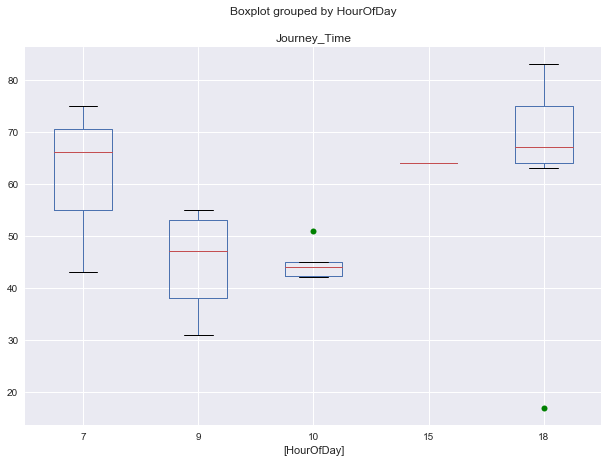

In [11]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
bp = df.boxplot(column=['Journey_Time'], by=['HourOfDay'], flierprops=flierprops, figsize=(10,7))
plt.savefig('Temp_to_late.pdf')

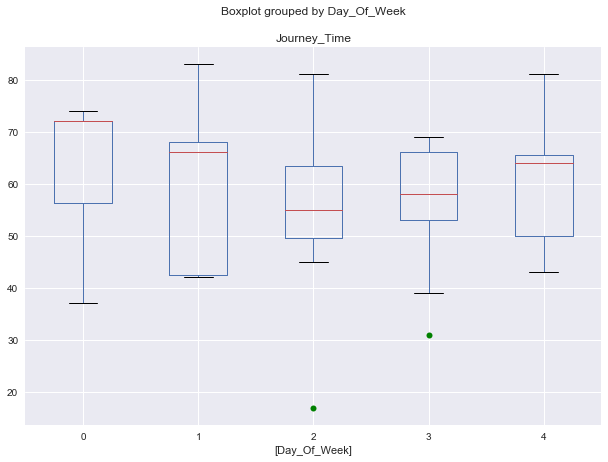

In [14]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
bp = df.boxplot(column=['Journey_Time'], by=['Day_Of_Week'], flierprops=flierprops, figsize=(10,7))
plt.savefig('Rain_to_DayOfWeek_chart.pdf')

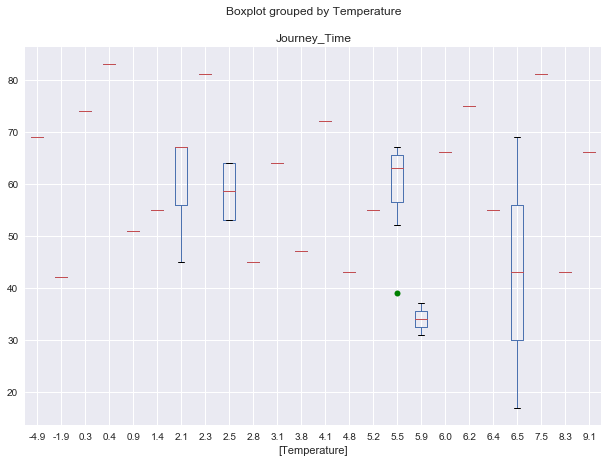

In [15]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
bp = df.boxplot(column=['Journey_Time'], by=['Temperature'], flierprops=flierprops, figsize=(10,7))
plt.savefig('Rain_to_late.pdf')

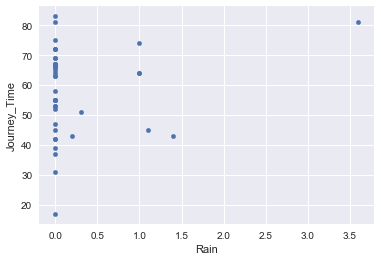

In [19]:
df.plot(kind = 'scatter', y='Journey_Time', x='Rain')

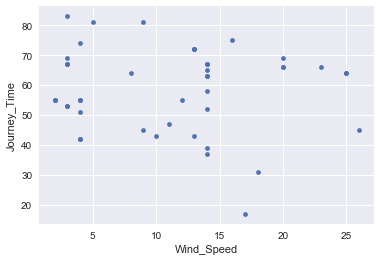

In [21]:
df.plot(kind = 'scatter', y='Journey_Time', x='Wind_Speed')

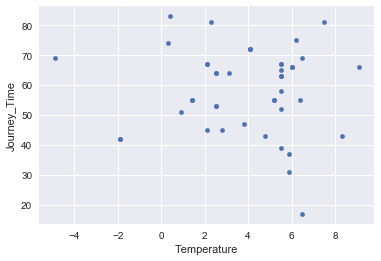

In [22]:
df.plot(kind = 'scatter', y='Journey_Time', x='Temperature')

(0, 100)

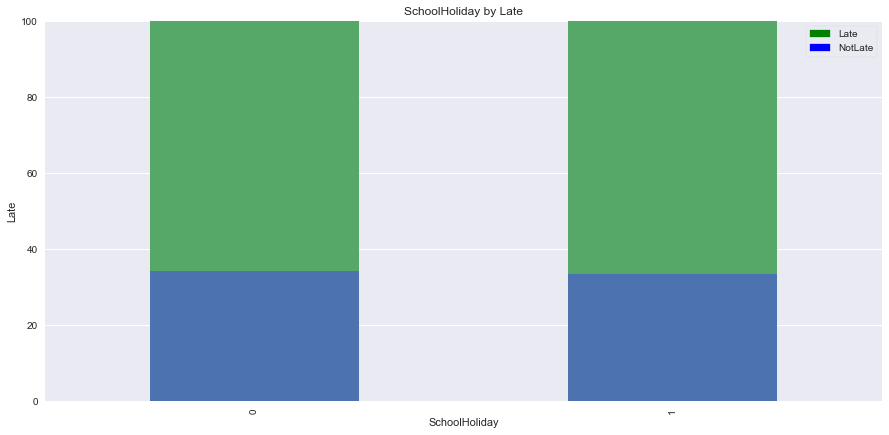

In [24]:
SchoolHoliday = pd.unique(df.SchoolHoliday.ravel())

# Insert a new column called 'percent' and fill it with 0s
df['percent'] = 0

for p in SchoolHoliday:
    count = 1 / df[df.SchoolHoliday == p].count()['Late']
    index_list = df[df['SchoolHoliday'] == p].index.tolist()
    for i in index_list:
        df.loc[i, 'percent'] = count * 100
        
# Group dataframe and sum percent
group = df[['percent','SchoolHoliday','Late']].groupby(['SchoolHoliday','Late']).sum()

# Plot values of group in a stacked bar chart
my_plot = group.unstack().plot(kind='bar', stacked=True, title="SchoolHoliday by Late", figsize=(15,7))

# Define label colours and text and add to the plot
red_patch = mpatches.Patch(color='green', label='Late')
blue_patch = mpatches.Patch(color='blue', label='NotLate')
my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

# Define x and y labels and min and max values for the y axis
my_plot.set_xlabel("SchoolHoliday")
my_plot.set_ylabel("Late")
my_plot.set_ylim([0,100])

(0, 100)

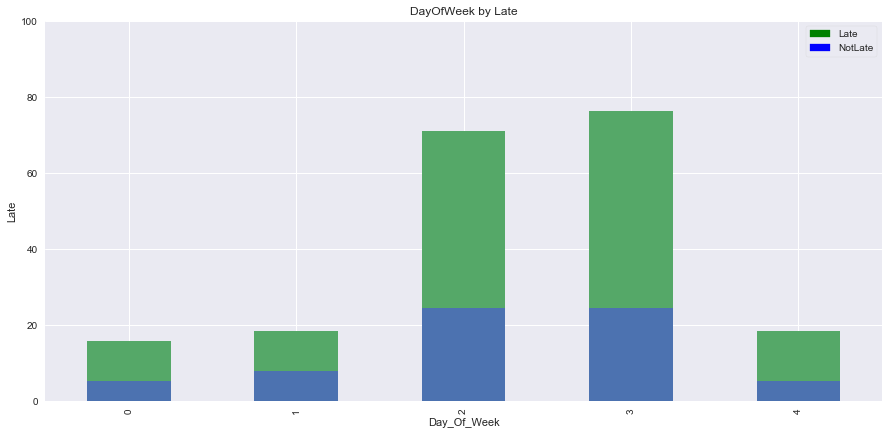

In [25]:
# Group dataframe  and sum percent
group = df[['percent','Day_Of_Week','Late']].groupby(['Day_Of_Week','Late']).sum()

# Plot values of group in a stacked bar chart
my_plot = group.unstack().plot(kind='bar', stacked=True, title="DayOfWeek by Late", figsize=(15,7))

# Define label colours and text and add to the plot
red_patch = mpatches.Patch(color='green', label='Late')
blue_patch = mpatches.Patch(color='blue', label='NotLate')
my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

# Define x and y labels and min and max values for the y axis
my_plot.set_xlabel("Day_Of_Week")
my_plot.set_ylabel("Late")
my_plot.set_ylim([0,100])

(0, 100)

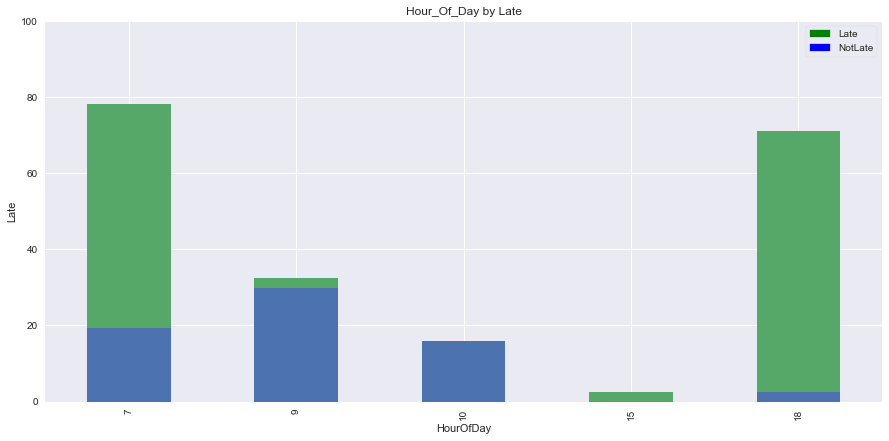

In [26]:
# Group dataframe and sum percent
group = df[['percent','Hour_Of_Day','Late']].groupby(['Hour_Of_Day','Late']).sum()

# Plot values of group in a stacked bar chart
my_plot = group.unstack().plot(kind='bar', stacked=True, title="Hour_Of_Day by Late", figsize=(15,7))

# Define label colours and text and add to the plot
red_patch = mpatches.Patch(color='green', label='Late')
blue_patch = mpatches.Patch(color='blue', label='NotLate')
my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

# Define x and y labels and min and max values for the y axis
my_plot.set_xlabel("HourOfDay")
my_plot.set_ylabel("Late")
my_plot.set_ylim([0,100])

# 4.0 Save DF to be used in Model Analysis

In [27]:
# Save cleaned dataframe to new CSV file
df.to_csv('csv_data/bus_route4_clean.csv', index=False)